<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter4.3_Visualizing_the_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Features

We will now visualize the features learned by the filters as well as look at the flattened layer, the one based on which the classification is done

In [1]:
#we get the dataset

!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2023-01-29 17:50:46--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5jh4hpuk2gcxaaq/all.zip [following]
--2023-01-29 17:50:46--  https://www.dropbox.com/s/raw/5jh4hpuk2gcxaaq/all.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe224d8ce8c317ba39d5c285ac.dl.dropboxusercontent.com/cd/0/inline/B1etFYR_I9_ws58I-A4TIpqJq1QMTAYhlVrMScah9bu8CrbJUVssA5GOlGEo-13w3p6iU1Q__miwib9jFbGi8d10PytGez75Hc8eCnVihaVGZXOJcFtD-9n0TcO1ovAM_HucpN2npu2nSpyEj4Hmu7ZdoX_9UZOsGK7qSEqM6YMi9w/file# [following]
--2023-01-29 17:50:46--  https://ucfe224d8ce8c317ba39d5c285ac.dl.dropboxusercontent.com/cd/0/inline/B1etFYR_I9_ws58I-A4TIpqJq1QMTAYhlVrMScah9bu8CrbJUVssA5GOlGEo-13w3p6iU1Q__miwib9jFbGi8d10PytGez7

We then import all the neccesary modules

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from imgaug import augmenters as iaa



We will now define a class that fetches data. We have to resize the images to 28 * 28 pixels, a batch has to be defined with three dimensions and the dependant variable is fetched as a numeric value.

In [3]:
tfm = iaa.Sequential(iaa.Resize(28)) #resize the images

class XO(Dataset):
  def __init__(self, folder):
    self.files = glob(folder)
  def __len__(self): return len(self.files)
  def __getitem__(self, ix):
    f = self.files[ix]
    im = tfm.augment_image(cv2.imread(f)[:,:,0]) #augment the image that is the file f
    im = im[None] #create a dummy channel before the height and width of an image
    cl = f.split('/')[-1].split('@')[0] == 'x' #in the file name, after / and before @ is the class name of the image
    return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

Let's look at the images we have obtained

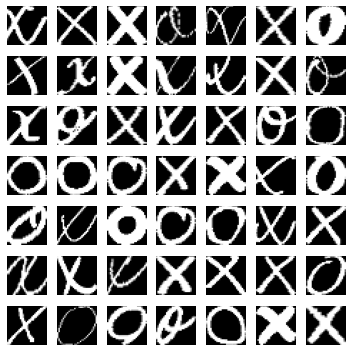

In [4]:
data = XO('/content/all/*')

R,C = 7,7
fig, ax = plt.subplots(R,C, figsize = (5,5))
for label_class, plot_row in enumerate(ax):
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(1000)
    im, label = data[ix]
    plot_cell.imshow(im[0].cpu(), cmap = 'gray')
plt.tight_layout()

Let's now define the model's architecture, loss_fn and optimizer

In [5]:
from torch.optim import SGD
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1,64, kernel_size = 3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64,128,kernel_size = 3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200, 256),
      nn.ReLU(),
      nn.Linear(256,1),
      nn.Sigmoid()
  ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr = 1e-3)
  return model, loss_fn, optimizer

Let's summarize the model. Also, the Binary Cross entropy loss is used because this is a binary classification problem

In [6]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,2

We now define a training function

In [7]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item(), is_correct[0]

We also create a Dataloader for the dataset

In [9]:
trn_dl = DataLoader(XO('/content/all/*'), batch_size = 32, drop_last = True )

In [8]:
model, loss_fn, optimizer = get_model()

We then train the model

In [10]:
for epoch in range(5):
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x,y,model, optimizer, loss_fn)

Fetch an image to see what the filters have learned about it

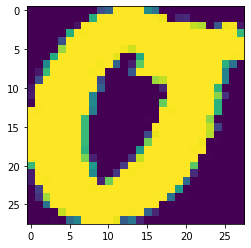

In [11]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

We will now pass the image through the model and fetch the output of the first layer, i.e. what the first 64 filters have learned about the images

In [13]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

Each channel in the intermediate output is the output of the convolution for the given filter i.e the 0 element is the result of convolving the first filter with the image

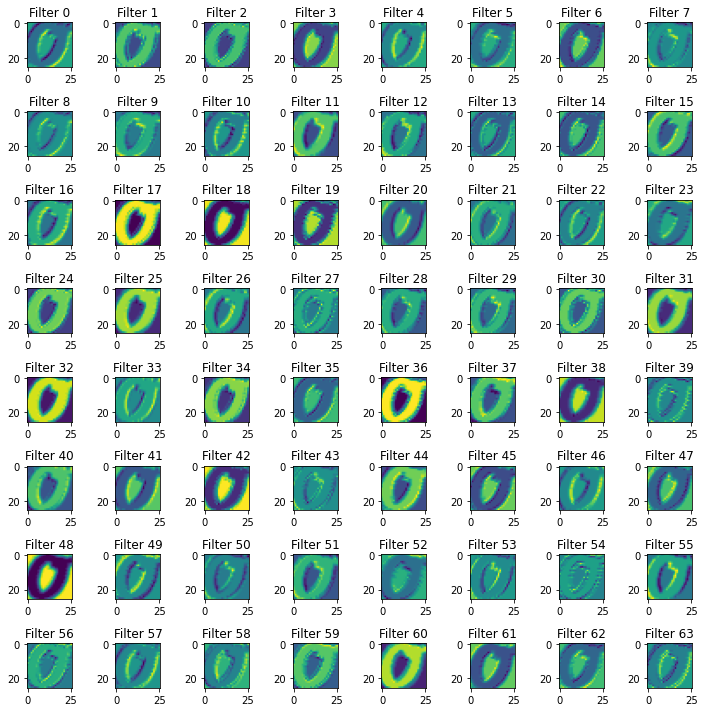

In [15]:
fig, ax = plt.subplots(8,8,figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.set_title(f'Filter {ix}')
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

We can see that some filters learn to invert the image, such as filter 18, while others such as 0,15,3,11 learn the edges of the image

Let's take the filter number 15 for example and check its behaviour across different 0 images in the dataset

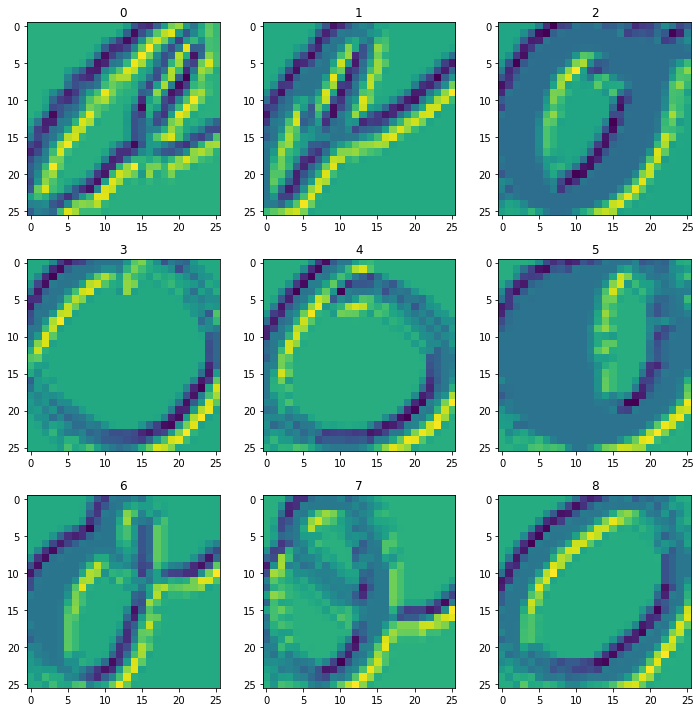

In [20]:
x, y = next(iter(trn_dl)) #get the dataset
x2 = x[y == 0] #get only the O images

x2 = x2.view(-1,1,28,28) #we reshape the images so they can enter the CNN

first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

n = 3 #number of images for visualization
layer_n = 0
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
 axis.imshow(first_layer_output[ix,layer_n,:,:].cpu()) 
 axis.set_title(str(ix))
plt.tight_layout()
plt.show()


Let's also see what the second convolutional layer i.e. the next set of filters have learned from the previous filters

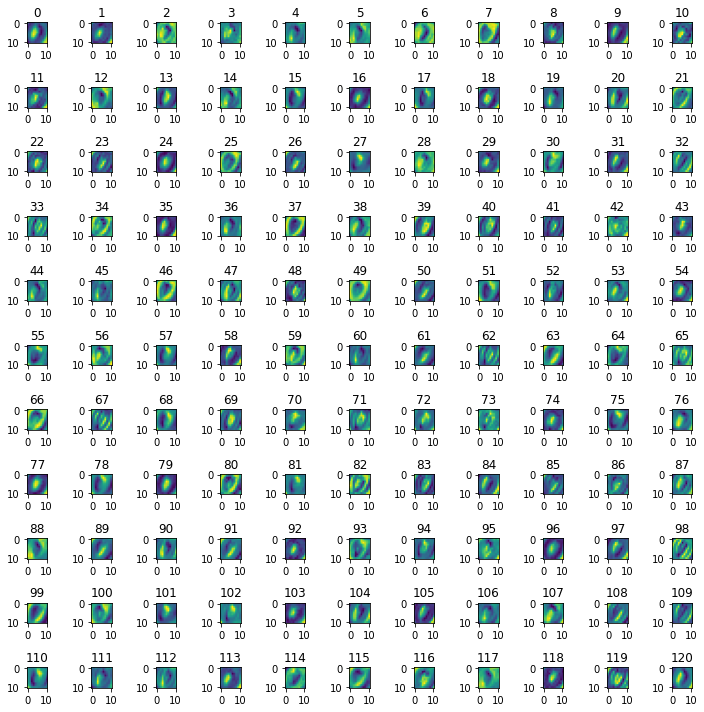

In [22]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

fig, ax = plt.subplots(11, 11, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
 axis.imshow(second_intermediate_output[ix].cpu())
 axis.set_title(str(ix))
plt.tight_layout()
plt.show()

Finally, let's see how the fully connected layer behaves with these images

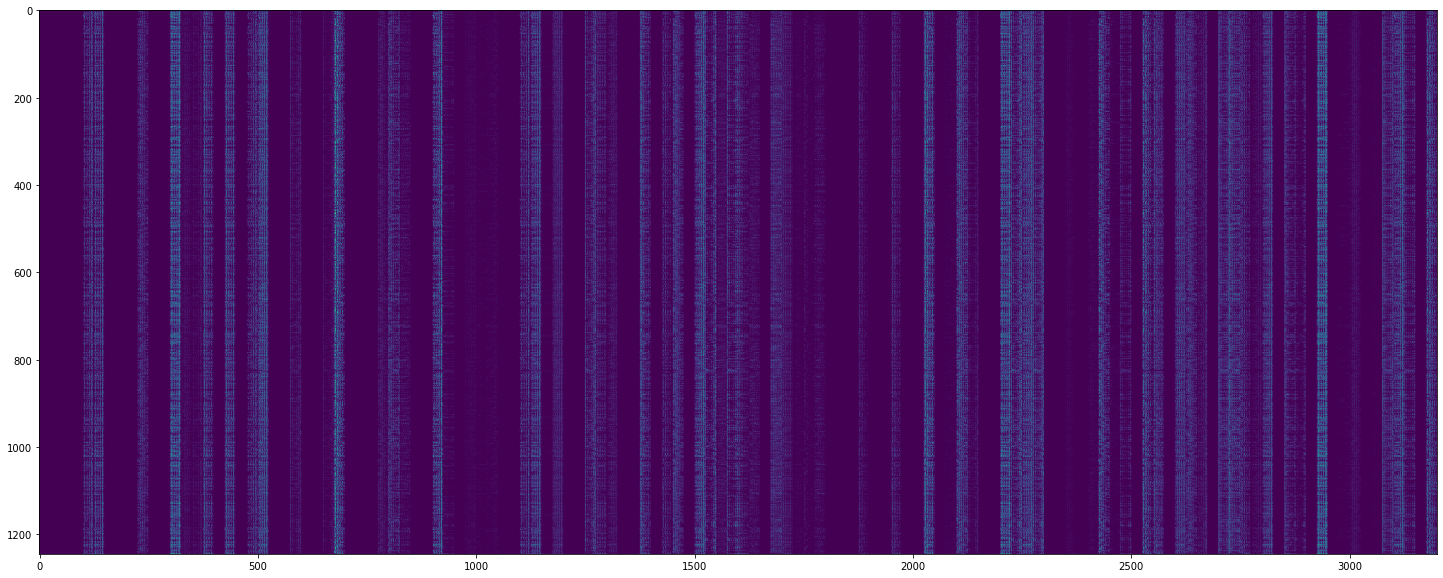

In [24]:
custom_dl = DataLoader(XO('/content/all/*'), batch_size = 2498, drop_last = True)

x,y = next(iter(custom_dl))
x2 = x[y == 0]
x2 = x2.view(len(x2), 1, 28, 28)

flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

plt.figure(figsize = (100,10))
plt.imshow(flatten_layer_output.cpu())

The output shape is 1245 * 3200 because we have 1245 O class examples in our dataset and there are 3200 dimensions for each image in the flattened layer i.e. the feature vector we have extracted has 3200 elements

The row in the image above is a feature vector for a given image. The white lines are actually consisted of dots, which represent which parts of the feature vector are used to classify the image. We can see that there are parts which are consistently used for this purpose.